In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 读取CSV文件
df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan.csv')

# 将日期列转换为datetime格式
df['date'] = pd.to_datetime(df['date'])

# 获取日期范围
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# 创建完整的日期DataFrame
complete_df = pd.DataFrame({'date': date_range})

# 与原始数据合并，保留所有日期
df_filled = pd.merge(complete_df, df, on='date', how='left')

# 将缺失值填充为NaN
df_filled = df_filled.fillna(np.nan)

# 读取蓝山嘴站点数据
tuoshan_df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/002-tuoshan.csv')
tuoshan_df['date'] = pd.to_datetime(tuoshan_df['date'])

# 将两个数据集按日期合并
merged_df = pd.merge(df_filled, tuoshan_df, on='date', how='left')

# 保存合并后的结果
merged_df.to_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv', index=False)

print("已完成数据合并，包含遥感特征和蓝山嘴站点数据")


已完成数据合并，包含遥感特征和蓝山嘴站点数据


In [8]:
# 读取已有的CSV文件
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 计算FAI (Floating Algae Index)
# FAI = (Rrc.859 - R'rc.859)/(Rrc.859 + R'rc.859)
# 其中 R'rc.859 = Rrc.645 + (Rrc.1240 - Rrc.645) * (859-645)/(1240-645)

# 使用b2(859nm)、b1(645nm)和b5(1240nm)波段计算FAI
R_rc859 = merged_df['b2']
R_rc645 = merged_df['b1'] 
R_rc1240 = merged_df['b5']

# 计算R'rc.859
R_rc859_prime = R_rc645 + (R_rc1240 - R_rc645) * (859-645)/(1240-645)

# 计算FAI
merged_df['fai'] = (R_rc859 - R_rc859_prime)/(R_rc859 + R_rc859_prime)

# 保存更新后的CSV文件
merged_df.to_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv', index=False)

print("FAI指数已重新计算并保存到CSV文件中")


FAI指数已重新计算并保存到CSV文件中


In [9]:
import numpy as np
import pandas as pd

# 读取CSV文件
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 定义异常值检测规则
anomaly_rules = {
    'evi': {'condition': lambda x: x < -1, 'name': 'EVI'},
    'ndvi': {'condition': lambda x: x < -1, 'name': 'NDVI'}, 
    'ndci': {'condition': lambda x: x > 1, 'name': 'NDCI'},
    'nrfi': {'condition': lambda x: x < -1, 'name': 'NRFI'}
}

# 遍历每个指标进行异常值检测和处理
for index, rule in anomaly_rules.items():
    # 找出异常值
    anomaly_mask = rule['condition'](merged_df[index])
    # 将异常值设置为NaN
    merged_df.loc[anomaly_mask, index] = np.nan
    print(f"已将{sum(anomaly_mask)}个{rule['name']}异常值设置为NaN")

# 保存处理后的结果
merged_df.to_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv', index=False)

print("异常值处理完成并已保存到CSV文件")


已将69个EVI异常值设置为NaN
已将5个NDVI异常值设置为NaN
已将3个NDCI异常值设置为NaN
已将2个NRFI异常值设置为NaN
异常值处理完成并已保存到CSV文件



藻密度与其他变量的相关性分析:
density         1.000000
temperature     0.367711
TP              0.253153
permanganate    0.216018
ndvi            0.158073
chla            0.092806
turbidity       0.087166
pH              0.073978
b2              0.057305
b4              0.047191
b5              0.046840
b3              0.043562
b1              0.041392
fai             0.037664
b6              0.016890
b7             -0.007542
evi            -0.012663
nrfi           -0.017729
ndci           -0.024220
ndwi           -0.045054
TN             -0.138082
conductivity   -0.182509
NH             -0.198847
oxygen         -0.281457
Name: density, dtype: float64


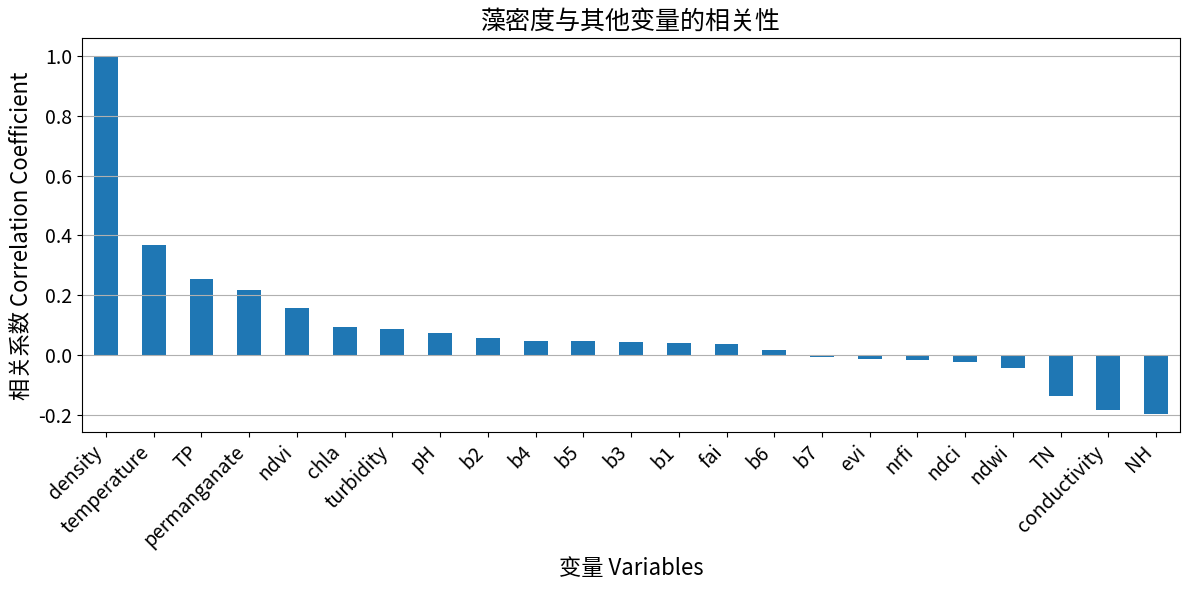

<Figure size 1200x1200 with 0 Axes>

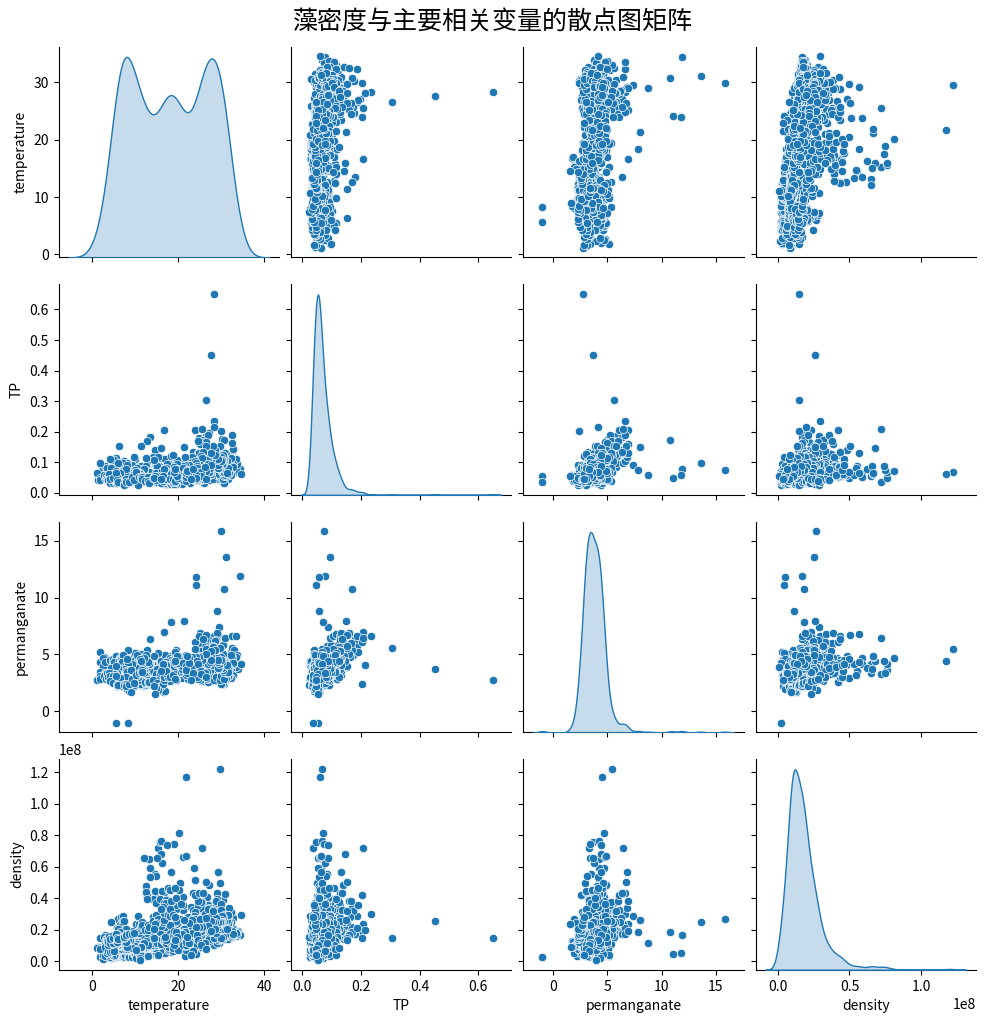


遥感指数与藻密度的相关性分析:
density    1.000000
ndvi       0.158073
fai        0.037664
evi       -0.012663
nrfi      -0.017729
ndci      -0.024220
ndwi      -0.045054
Name: density, dtype: float64

波段与藻密度的相关性分析:
density    1.000000
b2         0.057305
b4         0.047191
b5         0.046840
b3         0.043562
b1         0.041392
b6         0.016890
b7        -0.007542
Name: density, dtype: float64


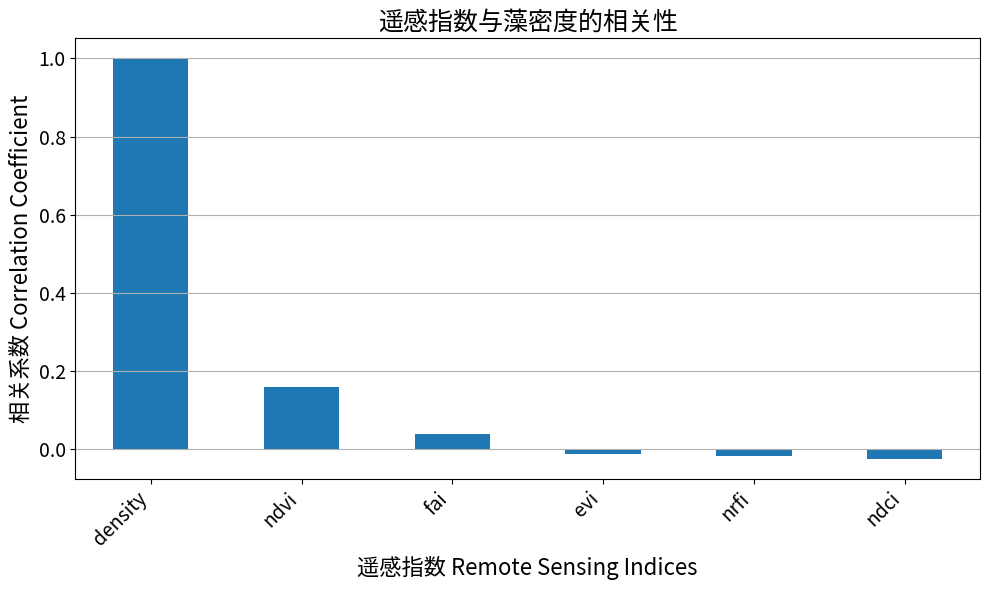

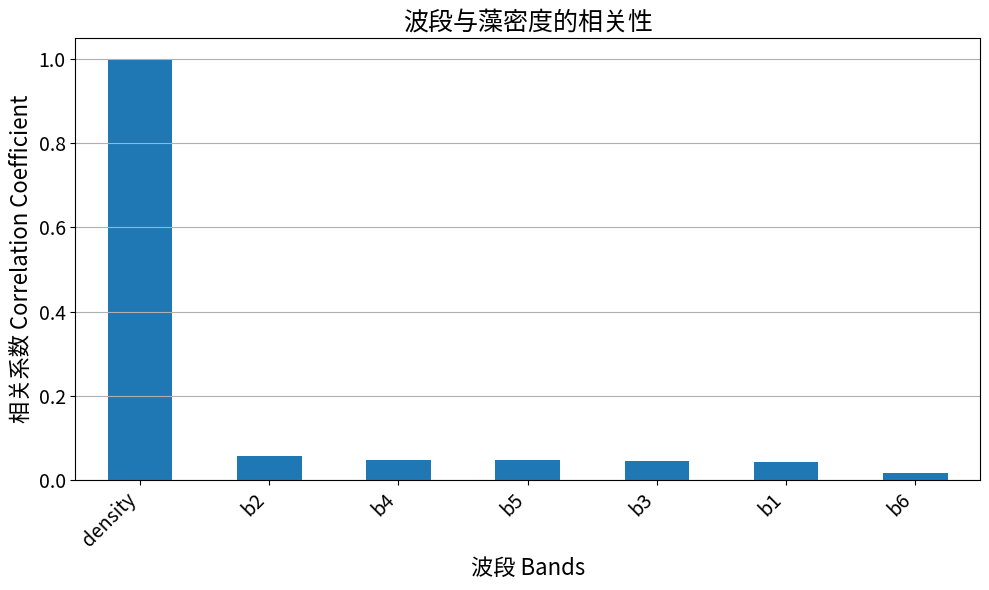

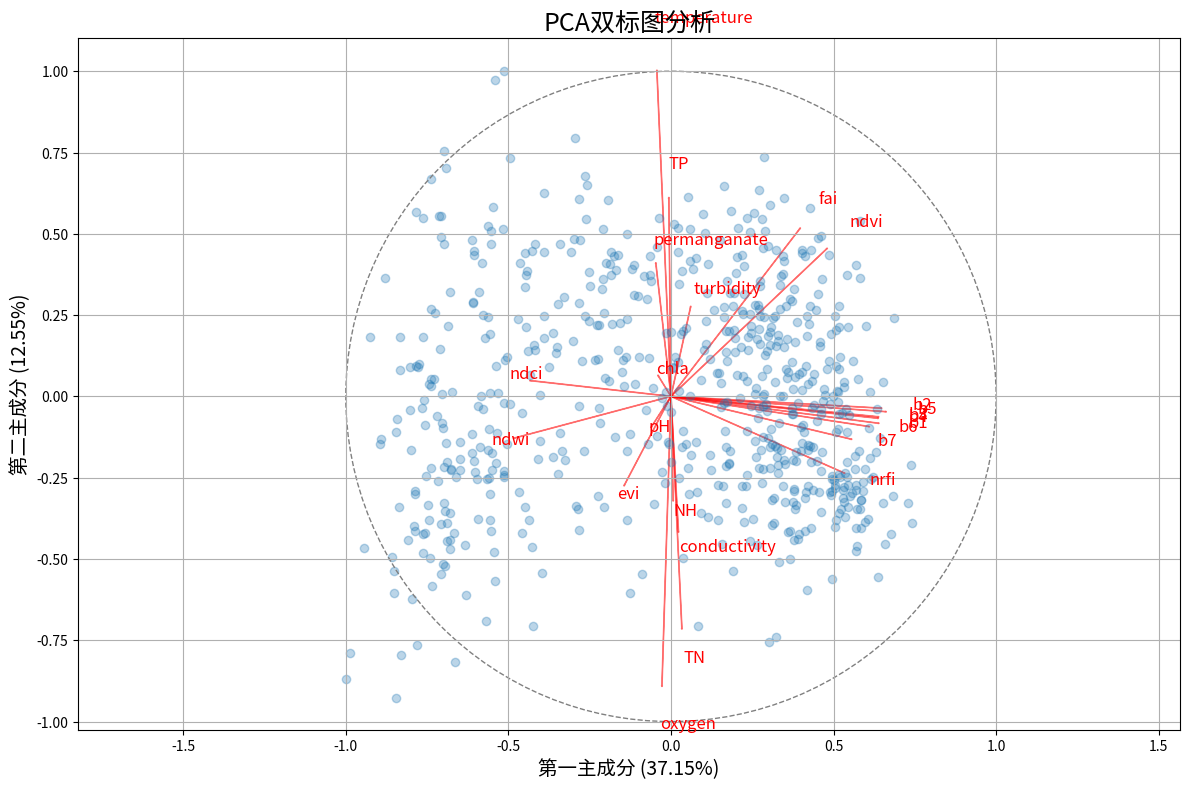

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# 读取数据
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 计算藻密度与其他变量的相关性
correlation_vars = ['temperature', 'pH', 'oxygen', 'permanganate', 'NH', 'TP', 'TN', 
                   'conductivity', 'turbidity', 'chla', 'ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi',
                   'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']  # 添加波段变量
correlations = merged_df[correlation_vars + ['density']].corr()['density'].sort_values(ascending=False)

# 打印相关性结果
print("\n藻密度与其他变量的相关性分析:")
print(correlations)

# 可视化相关性
plt.figure(figsize=(12, 6))
correlations[:-1].plot(kind='bar')
plt.title('藻密度与其他变量的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('变量 Variables', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制散点图矩阵
import seaborn as sns

# 选择相关性最强的4个变量,并确保density只出现一次
top_corr_vars = correlations.index[:4].tolist()
if 'density' in top_corr_vars:
    top_corr_vars.remove('density')
vars_to_plot = top_corr_vars + ['density']

# 检查数据是否为空
plot_data = merged_df[vars_to_plot].dropna()
if not plot_data.empty:
    plt.figure(figsize=(12, 12))
    sns.pairplot(plot_data, diag_kind='kde')
    plt.suptitle('藻密度与主要相关变量的散点图矩阵', y=1.02, fontproperties=chinese_font, fontsize=18)
    plt.show()
else:
    print("数据为空,无法绘制散点图矩阵")

# 计算遥感指数与藻密度的相关性
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
rs_correlations = merged_df[rs_vars + ['density']].corr()['density'].sort_values(ascending=False)

# 计算波段与藻密度的相关性
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
band_correlations = merged_df[band_vars + ['density']].corr()['density'].sort_values(ascending=False)

print("\n遥感指数与藻密度的相关性分析:")
print(rs_correlations)

print("\n波段与藻密度的相关性分析:")
print(band_correlations)

# 可视化遥感指数相关性
plt.figure(figsize=(10, 6))
rs_correlations[:-1].plot(kind='bar')
plt.title('遥感指数与藻密度的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('遥感指数 Remote Sensing Indices', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 可视化波段相关性
plt.figure(figsize=(10, 6))
band_correlations[:-1].plot(kind='bar')
plt.title('波段与藻密度的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('波段 Bands', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 进行PCA分析
# 选择要进行PCA分析的变量
pca_vars = correlation_vars  # 使用之前定义的所有变量

# 准备数据
X = merged_df[pca_vars].dropna()
X_scaled = StandardScaler().fit_transform(X)

# 执行PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# 计算解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 绘制PCA双标图
plt.figure(figsize=(12, 8))
scale = np.max(np.abs(pca.components_[:2]))

# 绘制变量向量
for i, var in enumerate(pca_vars):
    plt.arrow(0, 0,
              pca.components_[0, i] / scale,
              pca.components_[1, i] / scale,
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i] / scale * 1.15,
             pca.components_[1, i] / scale * 1.15,
             var, color='r', fontsize=12)

# 绘制样本点
plt.scatter(pca_result[:, 0] / np.max(np.abs(pca_result[:, 0])),
            pca_result[:, 1] / np.max(np.abs(pca_result[:, 1])),
            alpha=0.3)

# 添加标题和轴标签
plt.title('PCA双标图分析', fontproperties=chinese_font, fontsize=18)
plt.xlabel(f'第一主成分 ({explained_variance_ratio[0]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.ylabel(f'第二主成分 ({explained_variance_ratio[1]:.2%})', fontproperties=chinese_font, fontsize=14)

# 添加单位圆
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


叶绿素与其他变量的相关性分析:
chla            1.000000
pH              0.164431
permanganate    0.126431
density         0.092806
TN              0.037837
TP              0.026847
temperature     0.018211
turbidity       0.009703
nrfi            0.007749
ndwi            0.001989
ndci           -0.002846
b1             -0.015013
b4             -0.018991
b3             -0.019410
b2             -0.021702
b5             -0.029790
evi            -0.031020
b6             -0.033882
b7             -0.047873
oxygen         -0.052276
fai            -0.057848
ndvi           -0.065542
conductivity   -0.114174
NH             -0.166759
Name: chla, dtype: float64


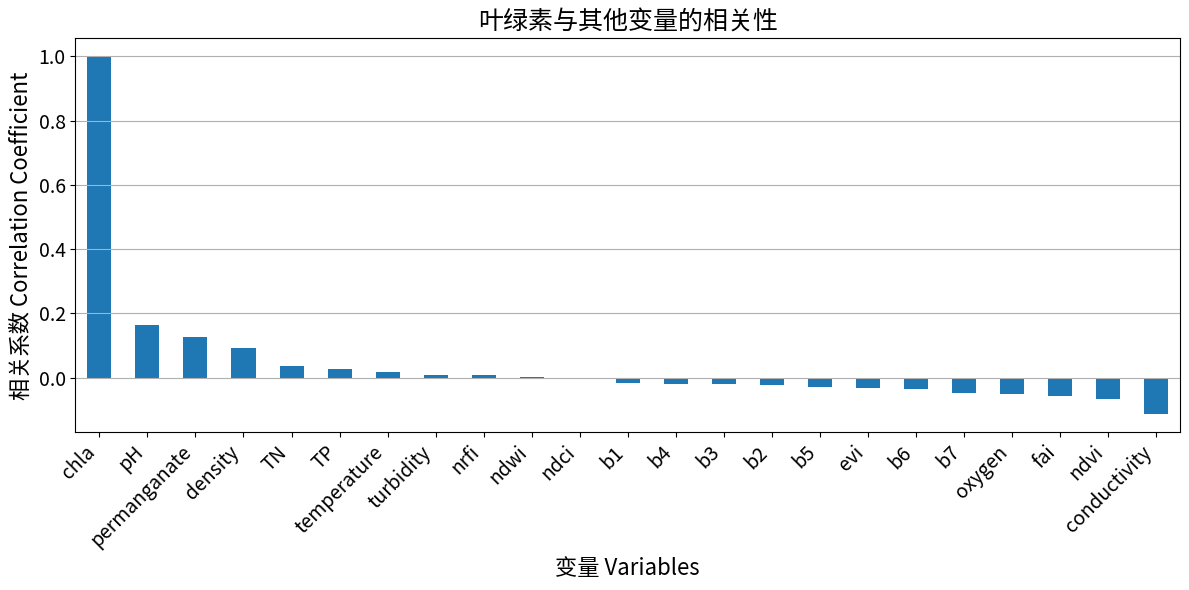

<Figure size 1200x1200 with 0 Axes>

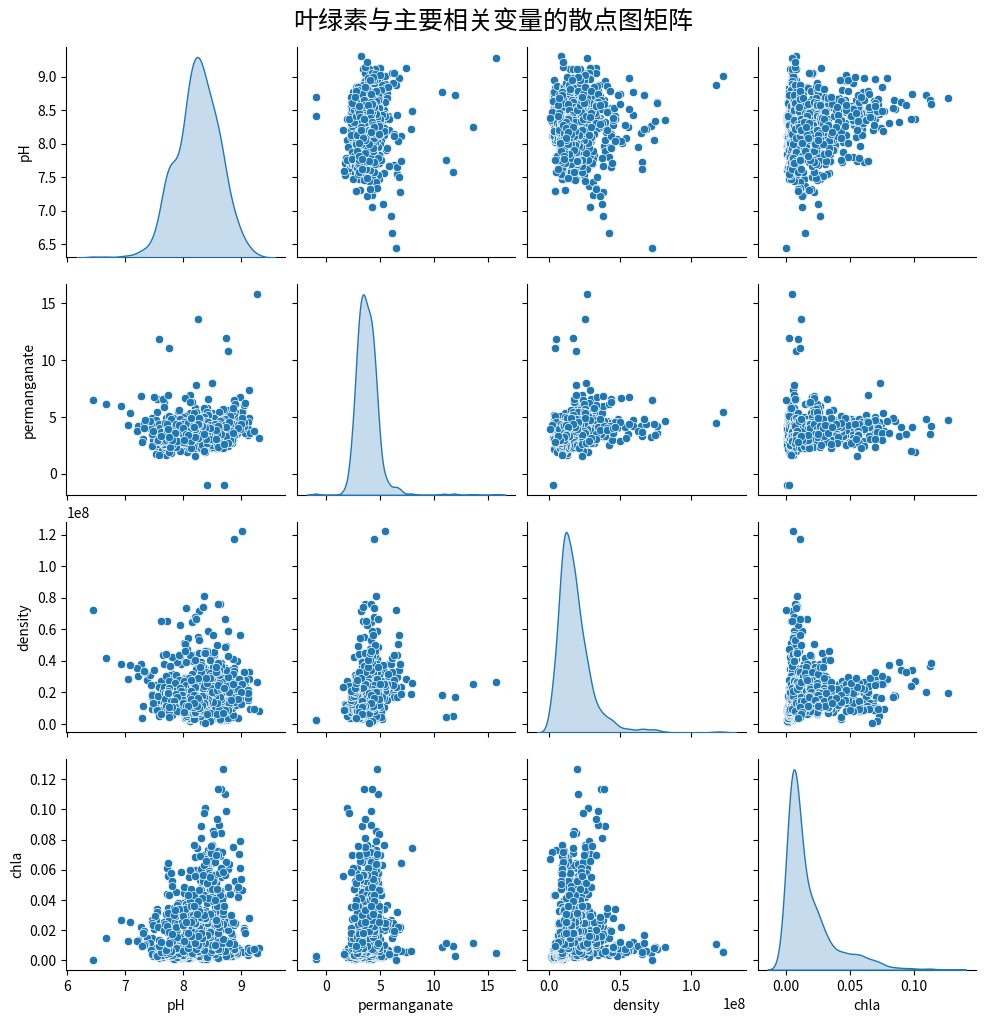


遥感指数与叶绿素的相关性分析:
chla    1.000000
nrfi    0.007749
ndwi    0.001989
ndci   -0.002846
evi    -0.031020
fai    -0.057848
ndvi   -0.065542
Name: chla, dtype: float64

波段与叶绿素的相关性分析:
chla    1.000000
b1     -0.015013
b4     -0.018991
b3     -0.019410
b2     -0.021702
b5     -0.029790
b6     -0.033882
b7     -0.047873
Name: chla, dtype: float64


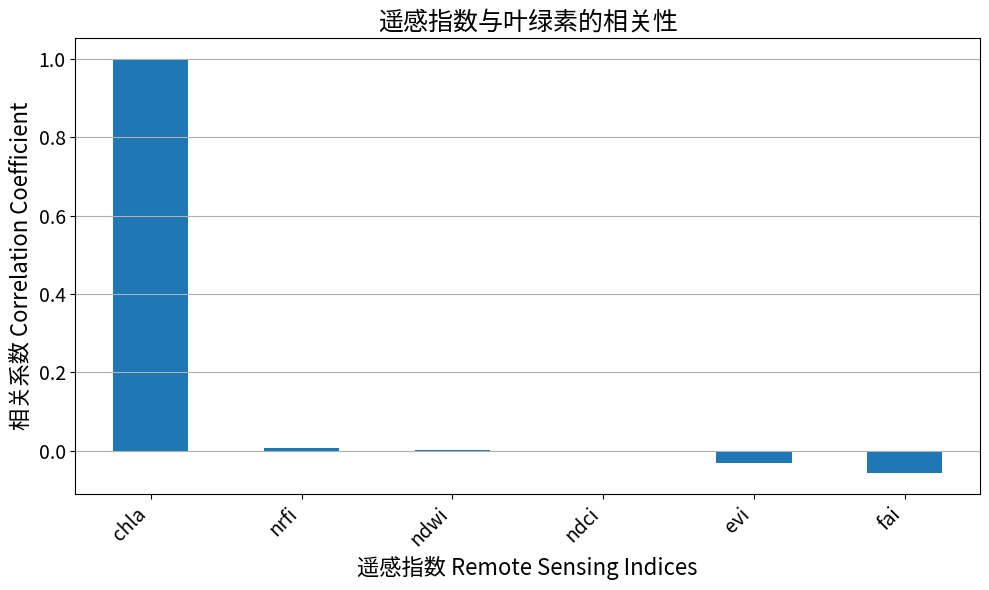

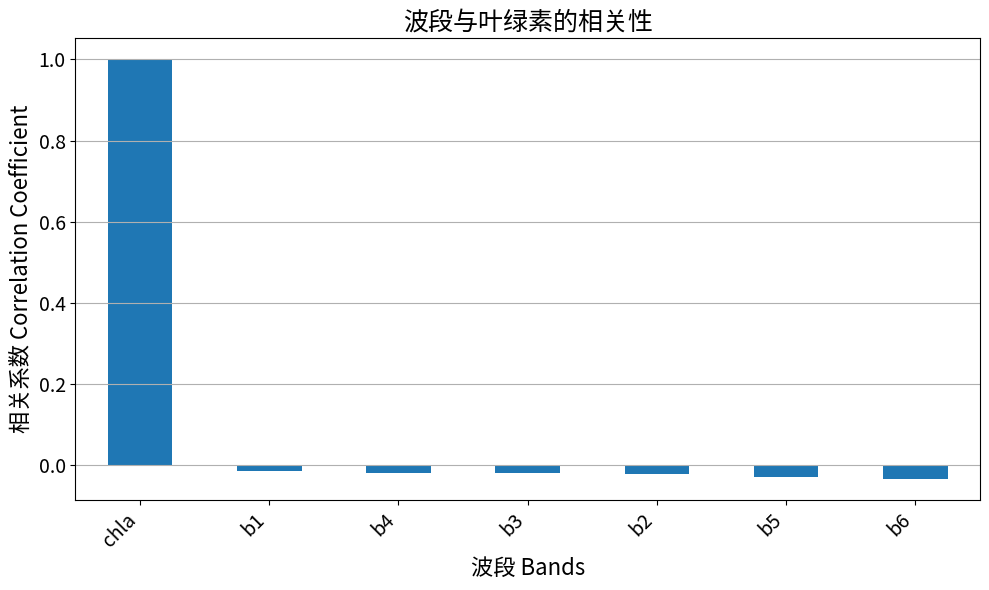

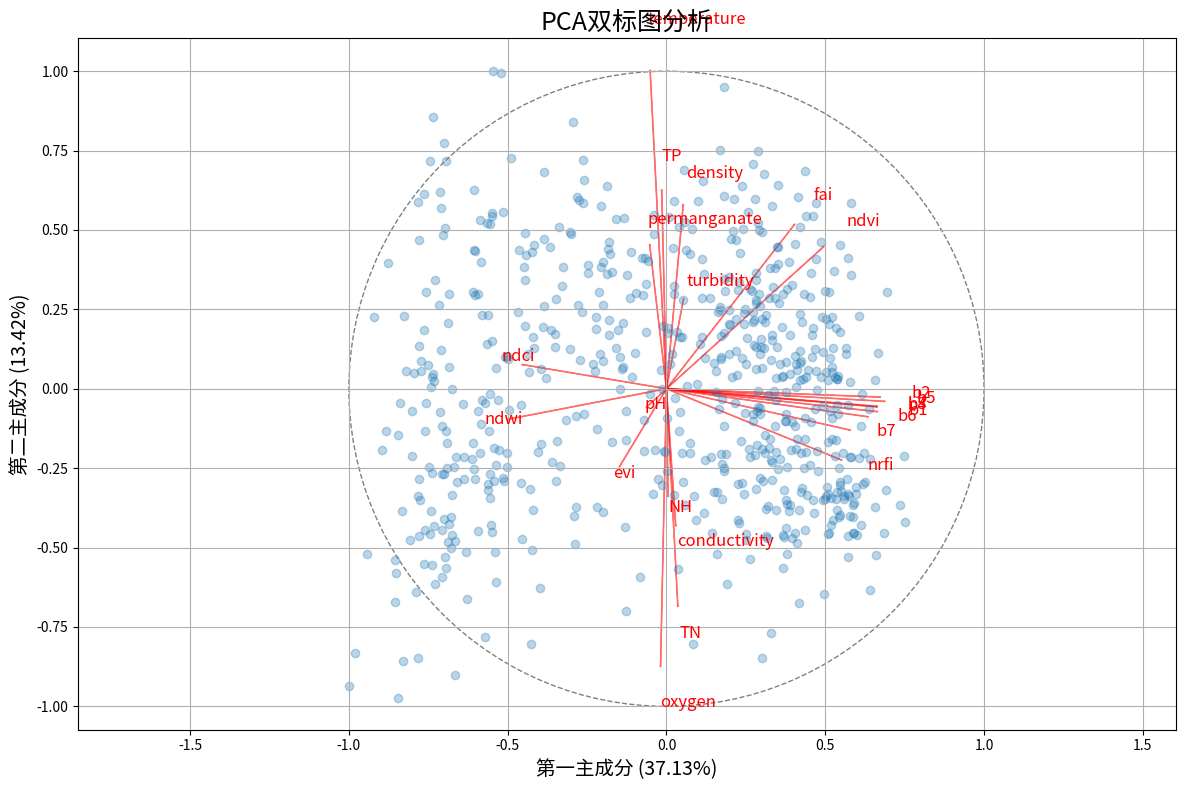

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# 读取数据
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 计算叶绿素与其他变量的相关性
correlation_vars = ['temperature', 'pH', 'oxygen', 'permanganate', 'NH', 'TP', 'TN', 
                   'conductivity', 'turbidity', 'density', 'ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi',
                   'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']  # 添加波段变量
correlations = merged_df[correlation_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

# 打印相关性结果
print("\n叶绿素与其他变量的相关性分析:")
print(correlations)

# 可视化相关性
plt.figure(figsize=(12, 6))
correlations[:-1].plot(kind='bar')
plt.title('叶绿素与其他变量的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('变量 Variables', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制散点图矩阵
import seaborn as sns

# 选择相关性最强的4个变量,并确保chla只出现一次
top_corr_vars = correlations.index[:4].tolist()
if 'chla' in top_corr_vars:
    top_corr_vars.remove('chla')
vars_to_plot = top_corr_vars + ['chla']

# 检查数据是否为空
plot_data = merged_df[vars_to_plot].dropna()
if not plot_data.empty:
    plt.figure(figsize=(12, 12))
    sns.pairplot(plot_data, diag_kind='kde')
    plt.suptitle('叶绿素与主要相关变量的散点图矩阵', y=1.02, fontproperties=chinese_font, fontsize=18)
    plt.show()
else:
    print("数据为空,无法绘制散点图矩阵")

# 计算遥感指数与叶绿素的相关性
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
rs_correlations = merged_df[rs_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

# 计算波段与叶绿素的相关性
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
band_correlations = merged_df[band_vars + ['chla']].corr()['chla'].sort_values(ascending=False)

print("\n遥感指数与叶绿素的相关性分析:")
print(rs_correlations)

print("\n波段与叶绿素的相关性分析:")
print(band_correlations)

# 可视化遥感指数相关性
plt.figure(figsize=(10, 6))
rs_correlations[:-1].plot(kind='bar')
plt.title('遥感指数与叶绿素的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('遥感指数 Remote Sensing Indices', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 可视化波段相关性
plt.figure(figsize=(10, 6))
band_correlations[:-1].plot(kind='bar')
plt.title('波段与叶绿素的相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('波段 Bands', fontproperties=chinese_font, fontsize=16)
plt.ylabel('相关系数 Correlation Coefficient', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 进行PCA分析
# 选择要进行PCA分析的变量
pca_vars = correlation_vars  # 使用之前定义的所有变量

# 准备数据
X = merged_df[pca_vars].dropna()
X_scaled = StandardScaler().fit_transform(X)

# 执行PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# 计算解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 绘制PCA双标图
plt.figure(figsize=(12, 8))
scale = np.max(np.abs(pca.components_[:2]))

# 绘制变量向量
for i, var in enumerate(pca_vars):
    plt.arrow(0, 0,
              pca.components_[0, i] / scale,
              pca.components_[1, i] / scale,
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i] / scale * 1.15,
             pca.components_[1, i] / scale * 1.15,
             var, color='r', fontsize=12)

# 绘制样本点
plt.scatter(pca_result[:, 0] / np.max(np.abs(pca_result[:, 0])),
            pca_result[:, 1] / np.max(np.abs(pca_result[:, 1])),
            alpha=0.3)

# 添加标题和轴标签
plt.title('PCA双标图分析', fontproperties=chinese_font, fontsize=18)
plt.xlabel(f'第一主成分 ({explained_variance_ratio[0]:.2%})', fontproperties=chinese_font, fontsize=14)
plt.ylabel(f'第二主成分 ({explained_variance_ratio[1]:.2%})', fontproperties=chinese_font, fontsize=14)

# 添加单位圆
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

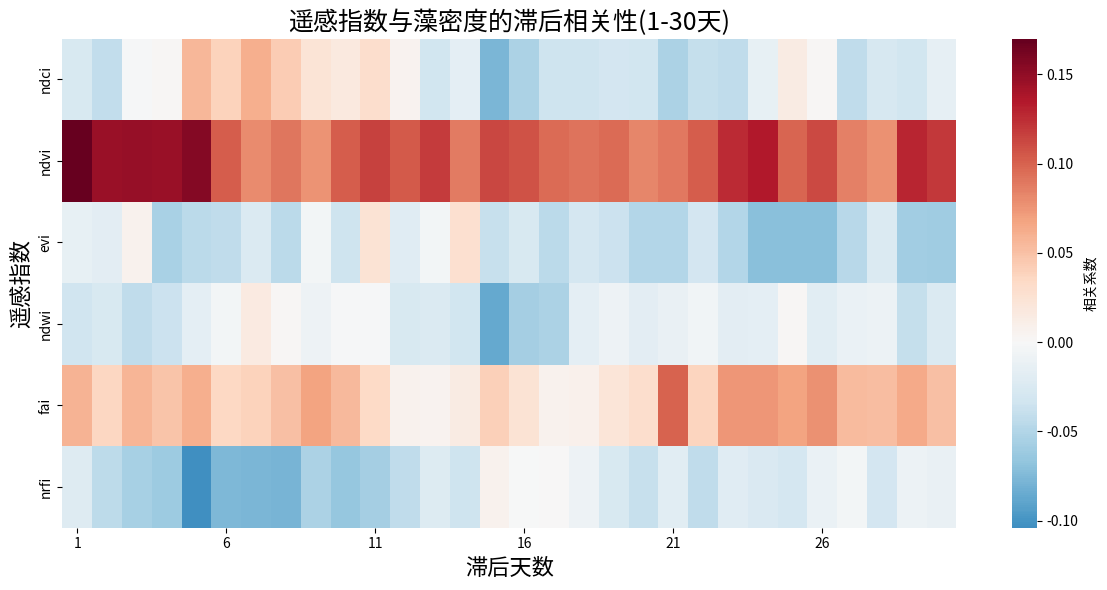

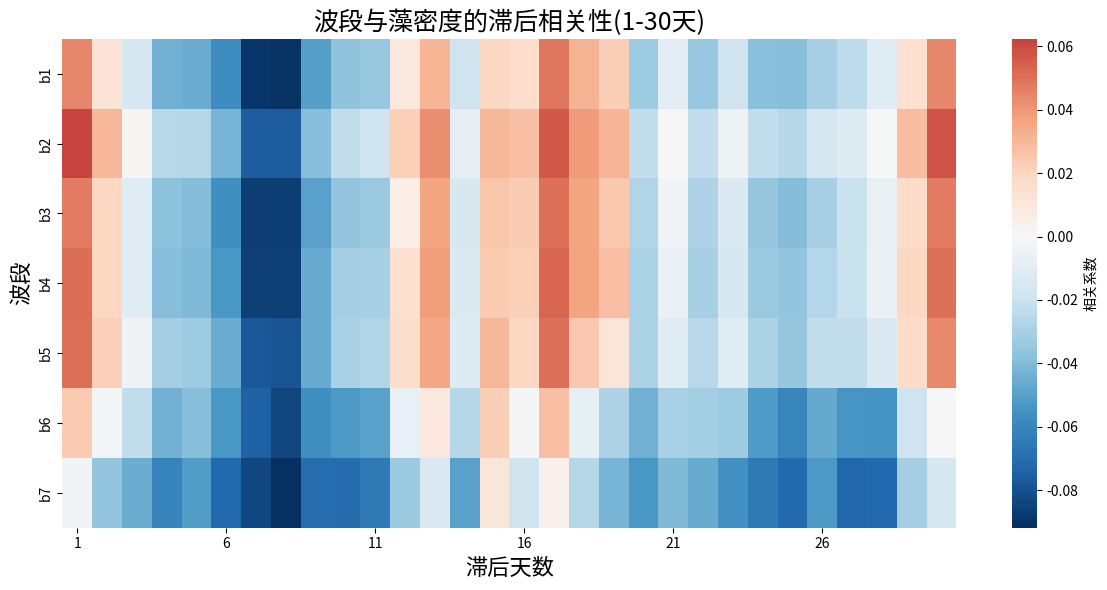


遥感指数的最大滞后相关性及对应滞后天数:
ndci: 相关系数 = -0.076, 滞后天数 = 15
ndvi: 相关系数 = 0.170, 滞后天数 = 1
evi: 相关系数 = -0.071, 滞后天数 = 24
ndwi: 相关系数 = -0.086, 滞后天数 = 15
fai: 相关系数 = 0.100, 滞后天数 = 21
nrfi: 相关系数 = -0.104, 滞后天数 = 5

波段的最大滞后相关性及对应滞后天数:
b1: 相关系数 = -0.090, 滞后天数 = 8
b2: 相关系数 = -0.076, 滞后天数 = 8
b3: 相关系数 = -0.087, 滞后天数 = 8
b4: 相关系数 = -0.086, 滞后天数 = 8
b5: 相关系数 = -0.079, 滞后天数 = 8
b6: 相关系数 = -0.084, 滞后天数 = 8
b7: 相关系数 = -0.092, 滞后天数 = 8


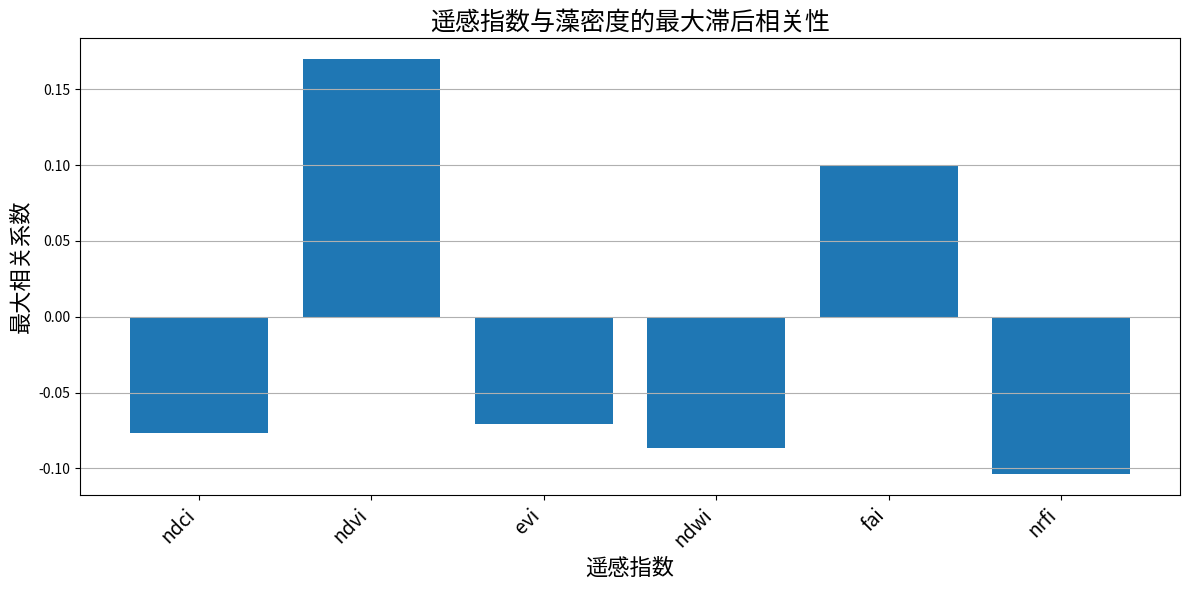

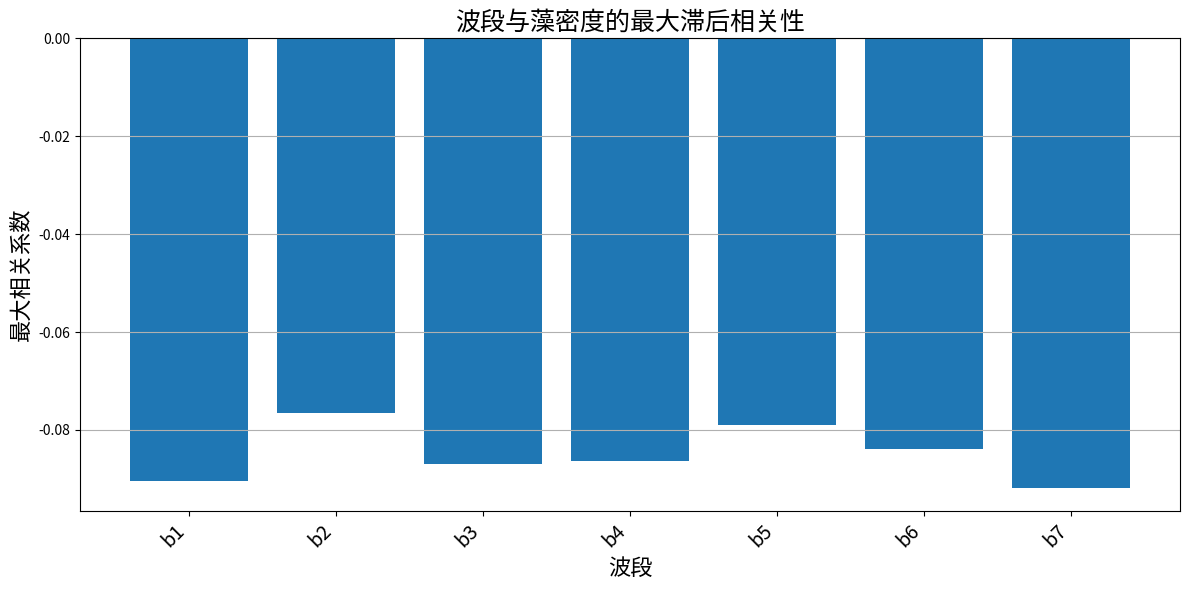

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# 读取数据
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 定义遥感指数和波段变量
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']

# 计算滞后相关性
max_lag = 30  # 最大滞后天数

# 遥感指数的滞后相关性分析
rs_lag_correlations = {}
for var in rs_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['density'])
        lag_corrs.append(lagged_corr)
    rs_lag_correlations[var] = lag_corrs

# 波段的滞后相关性分析
band_lag_correlations = {}
for var in band_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['density'])
        lag_corrs.append(lagged_corr)
    band_lag_correlations[var] = lag_corrs

# 绘制遥感指数滞后相关性热力图
plt.figure(figsize=(12, 6))
rs_lag_data = pd.DataFrame(rs_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(rs_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('遥感指数与藻密度的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('遥感指数', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 绘制波段滞后相关性热力图
plt.figure(figsize=(12, 6))
band_lag_data = pd.DataFrame(band_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(band_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('波段与藻密度的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('波段', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 找出遥感指数的最大滞后相关性
rs_max_lag_correlations = {}
for var in rs_vars:
    max_corr = max(rs_lag_correlations[var], key=abs)
    max_lag = rs_lag_correlations[var].index(max_corr) + 1
    rs_max_lag_correlations[var] = (max_corr, max_lag)

# 找出波段的最大滞后相关性
band_max_lag_correlations = {}
for var in band_vars:
    max_corr = max(band_lag_correlations[var], key=abs)
    max_lag = band_lag_correlations[var].index(max_corr) + 1
    band_max_lag_correlations[var] = (max_corr, max_lag)

print("\n遥感指数的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in rs_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

print("\n波段的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in band_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 绘制遥感指数最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
rs_max_corrs = [corr for corr, _ in rs_max_lag_correlations.values()]
plt.bar(rs_max_lag_correlations.keys(), rs_max_corrs)
plt.title('遥感指数与藻密度的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制波段最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
band_max_corrs = [corr for corr, _ in band_max_lag_correlations.values()]
plt.bar(band_max_lag_correlations.keys(), band_max_corrs)
plt.title('波段与藻密度的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

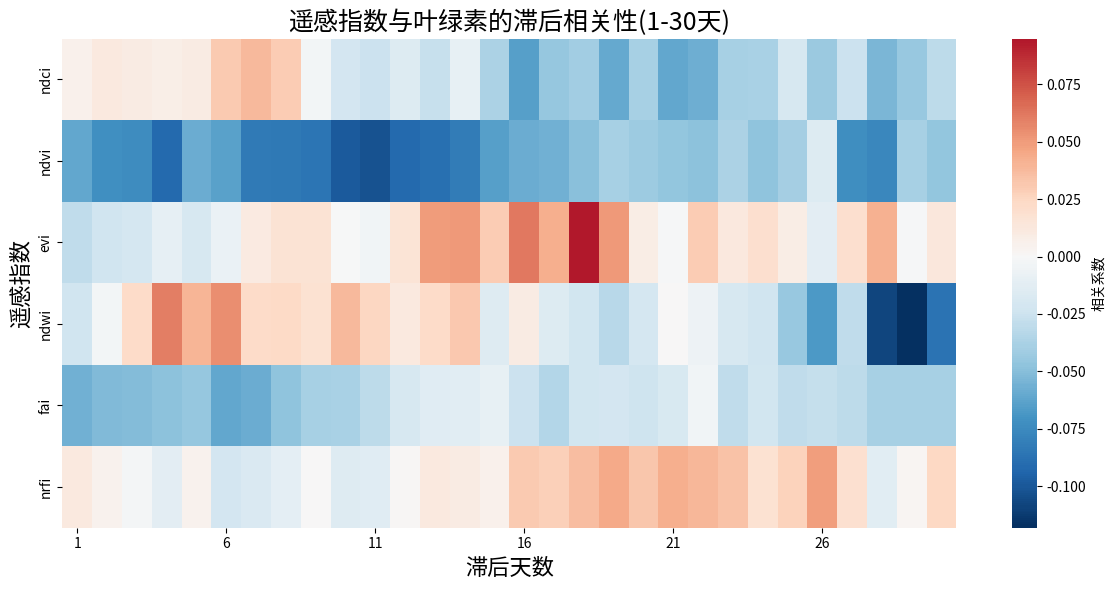

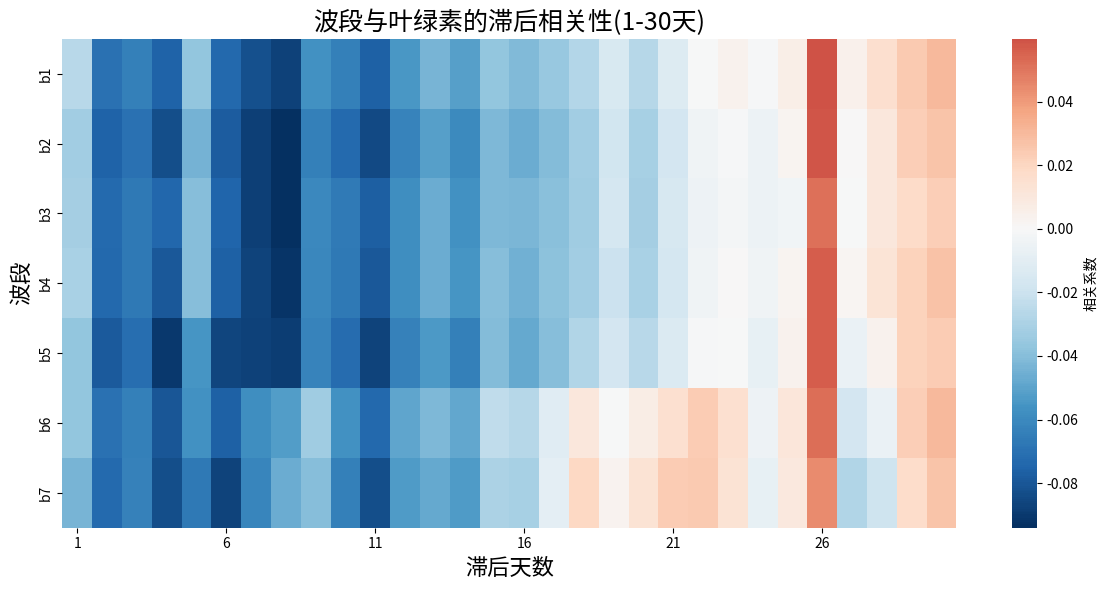


遥感指数的最大滞后相关性及对应滞后天数:
ndci: 相关系数 = -0.065, 滞后天数 = 16
ndvi: 相关系数 = -0.103, 滞后天数 = 11
evi: 相关系数 = 0.095, 滞后天数 = 18
ndwi: 相关系数 = -0.118, 滞后天数 = 29
fai: 相关系数 = -0.061, 滞后天数 = 6
nrfi: 相关系数 = 0.049, 滞后天数 = 26

波段的最大滞后相关性及对应滞后天数:
b1: 相关系数 = -0.088, 滞后天数 = 8
b2: 相关系数 = -0.094, 滞后天数 = 8
b3: 相关系数 = -0.093, 滞后天数 = 8
b4: 相关系数 = -0.092, 滞后天数 = 8
b5: 相关系数 = -0.091, 滞后天数 = 4
b6: 相关系数 = -0.080, 滞后天数 = 4
b7: 相关系数 = -0.087, 滞后天数 = 6


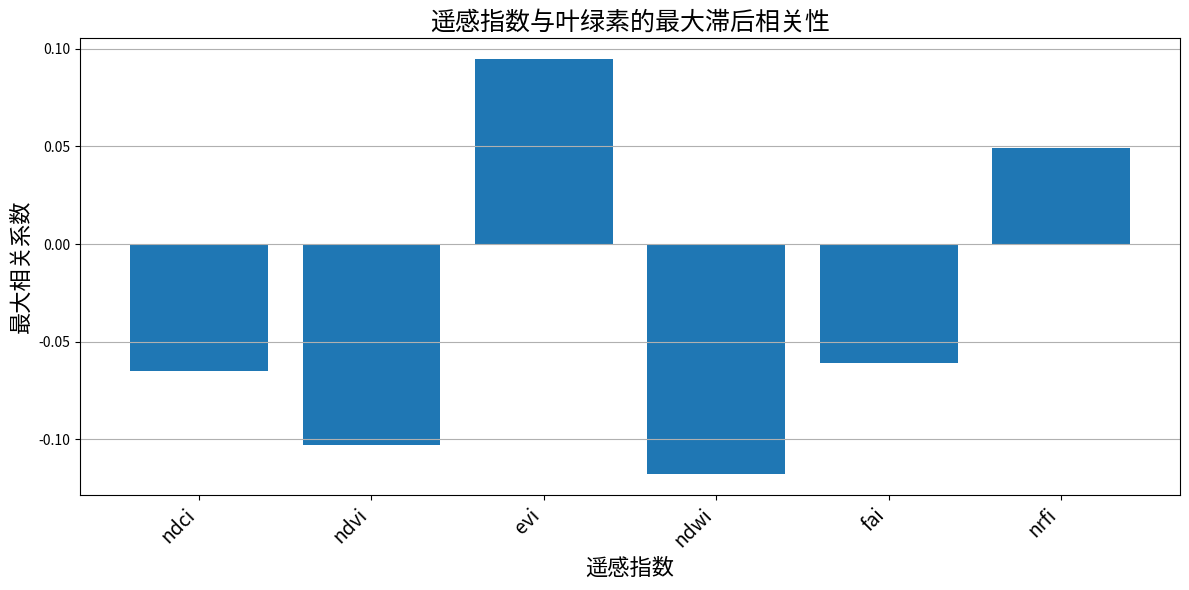

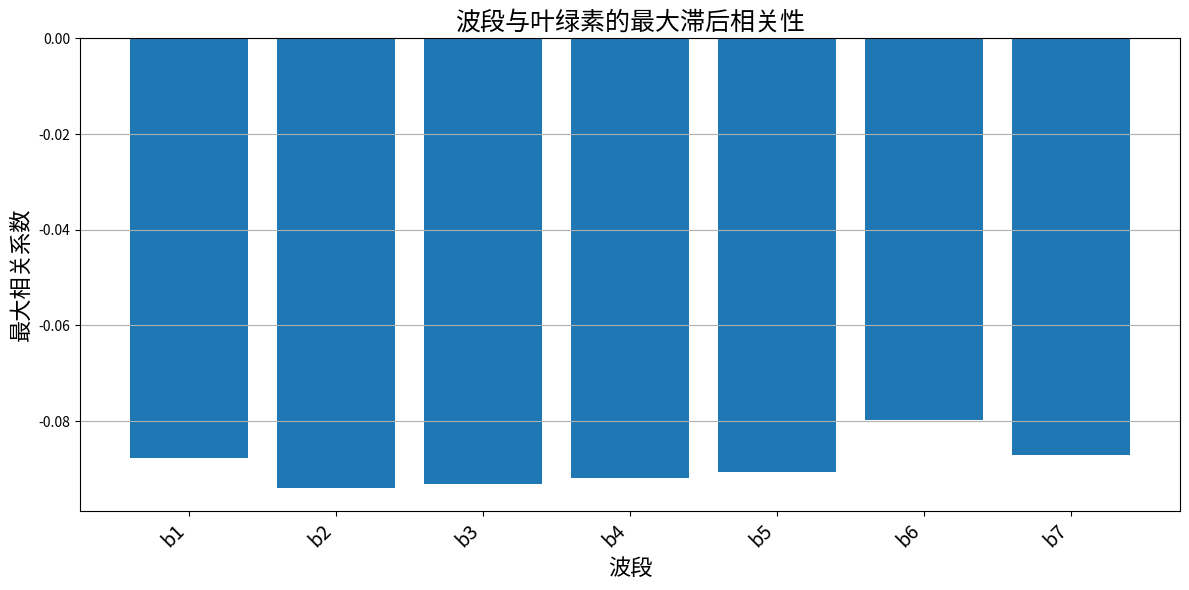

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# 读取数据
merged_df = pd.read_csv('/root/Download/Modis-algae-aliyun/aie-taihu/特征和密度结果_MODIS_MOD09GA_061_20241106_tuoshan-merged.csv')

# 定义遥感指数和波段变量
rs_vars = ['ndci', 'ndvi', 'evi', 'ndwi', 'fai', 'nrfi']
band_vars = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']

# 计算滞后相关性
max_lag = 30  # 最大滞后天数

# 遥感指数的滞后相关性分析
rs_lag_correlations = {}
for var in rs_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['chla'])
        lag_corrs.append(lagged_corr)
    rs_lag_correlations[var] = lag_corrs

# 波段的滞后相关性分析
band_lag_correlations = {}
for var in band_vars:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        lagged_corr = merged_df[var].shift(lag).corr(merged_df['chla'])
        lag_corrs.append(lagged_corr)
    band_lag_correlations[var] = lag_corrs

# 绘制遥感指数滞后相关性热力图
plt.figure(figsize=(12, 6))
rs_lag_data = pd.DataFrame(rs_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(rs_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('遥感指数与叶绿素的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('遥感指数', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 绘制波段滞后相关性热力图
plt.figure(figsize=(12, 6))
band_lag_data = pd.DataFrame(band_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(band_lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('波段与叶绿素的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('波段', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 找出遥感指数的最大滞后相关性
rs_max_lag_correlations = {}
for var in rs_vars:
    max_corr = max(rs_lag_correlations[var], key=abs)
    max_lag = rs_lag_correlations[var].index(max_corr) + 1
    rs_max_lag_correlations[var] = (max_corr, max_lag)

# 找出波段的最大滞后相关性
band_max_lag_correlations = {}
for var in band_vars:
    max_corr = max(band_lag_correlations[var], key=abs)
    max_lag = band_lag_correlations[var].index(max_corr) + 1
    band_max_lag_correlations[var] = (max_corr, max_lag)

print("\n遥感指数的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in rs_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

print("\n波段的最大滞后相关性及对应滞后天数:")
for var, (corr, lag) in band_max_lag_correlations.items():
    print(f"{var}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 绘制遥感指数最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
rs_max_corrs = [corr for corr, _ in rs_max_lag_correlations.values()]
plt.bar(rs_max_lag_correlations.keys(), rs_max_corrs)
plt.title('遥感指数与叶绿素的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('遥感指数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 绘制波段最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
band_max_corrs = [corr for corr, _ in band_max_lag_correlations.values()]
plt.bar(band_max_lag_correlations.keys(), band_max_corrs)
plt.title('波段与叶绿素的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('波段', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()